In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('diabetes/diabetic_data_balanced.csv')

In [3]:
data = pd.read_csv('diabetes/diabetic_data_balanced.csv')

row_drop = data.loc[data.discharge_disposition_id == 11].index      # Drop patients who died from the data
row_drop.append(data.loc[data.discharge_disposition_id == 13].index)# Drop patients who were transferred to
row_drop.append(data.loc[data.discharge_disposition_id == 14].index)# another hospice from the data.
data.drop(row_drop, inplace=True, axis=0)
data.dropna(subset=['race'], inplace=True)            
# Cannot produce a meaningful filler value. Best to drop.

# Data exploration suggested that an indication of whether the glucose serum test was conducted at all might
# be more useful than tetrary feature.
data['booleanGlucose'] = list(map(int, (data.max_glu_serum != 'None')))

# Many possible values for discharge_disposition. Group them into internally similar groups.
def group_discharge(did):
    if did in [18,25,26]:
        return "NULL"
    elif did in [3,4,5]:
        return "ICF/SNF"
    elif did in [6,8,12]:
        return "FURTHER_CARE_HOME"
    elif did in [7]:
        return "LEFT_AMA"
    elif did in [15,17,9]:
        return "CARE_CONTINUES_IN_THIS_HOSPITAL"
    else:
        return "CARE_CONTINUES_ELSEWHERE"
    
data['discharge_disposition_cat'] = data.discharge_disposition_id.map(group_discharge)
data['discharge_disposition_id'] = data.discharge_disposition_id.map(str)

# Same principle for Admission Source.
def group_ad_source(asid):
    if asid in [17,20,9]:
        return "NULL"
    elif asid in [1,2,3]:
        return "REFERRAL"
    elif asid in [4,5,6]:
        return "TRANSFER"
    elif asid in [7]:
        return "E.R."
    elif asid in [8]:
        return "LAW_ENFORCEMENT"
    else:
        return "OTHER"

data['admission_source_cat'] = data.admission_source_id.map(group_ad_source)
data['admission_source_id'] = data.admission_source_id.map(str)

# Translate admission type to readable form + sanitise NULLs.
def transcribe_ad_t(atid):
    cats = [0, "Emergency","Urgent","Elective","Newborn", "NULL", "NULL", "Trauma Center", "NULL"]
    if atid in [5,6,8]:
        return "NULL"
    return cats[atid]

data['admission_type_cat'] = data.admission_type_id.map(transcribe_ad_t)
data['admission_type_id'] = data.admission_type_id.map(str)

# Get rid of the mess that the generics are.
# This tries to achieve the goal by creating 3 numerical features (one for each category except 'No') 
# that measures the number of instances of this category in the sample.
 
generics = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
            'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
            'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin', 'glyburide-metformin', 
            'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
            'metformin-pioglitazone']

data['UP'] = np.sum([data[g] == 'Up' for g in generics], axis=0)
data['STEADY'] = np.sum([data[g] == 'Steady' for g in generics], axis=0)
data['DOWN'] = np.sum([data[g] == 'Down' for g in generics], axis=0)

# Age category lends itself to being made numerical. Update this feature accordingly.
data['age'] = data.age.map(lambda a: int(a[1]))

# We may find that the sum of total visits in the preceding year is more informative 
# than the three indivdual ones.
# We may then choose to cap at some value calculated based on the training set to obtain
# fewer values with more representation each.

data['total_visits'] = data.number_emergency + data.number_inpatient + data.number_outpatient


# Get a better representation for the diagnoses
def cat(diag):
    if (type(diag) == float and np.isnan(diag)) or diag == "NaN":
        return "NULL"
    try:
        num = int(diag)
    except Exception as e:
        if diag[0] == 'E':
            return "SUPP_CLASS_EXTERNAL_CAUSE"
        elif diag[0] == 'V':
            return "SUPP_CLASS_HEALTH_FACTORS"
        else:
            try:
                num = float(diag)
                return "DIABETES"
            except Exception as ex:
                return "ERROR"
    if (num >= 390 and num <= 459) or num == 785:
        return "CIRCULATORY"
    elif (num >= 460 and num <= 519) or num == 786:
        return "RESPIRATORY"
    elif (num >= 520 and num <= 579) or num == 787:
        return "DIGESTIVE"
    elif num >= 800: 
        return "INJURY_OR_POISON"
    elif num >= 710 and num <= 739:
        return "MUSKOSKELETAL"
    elif (num >= 580 and num <= 629) or num == 788:
        return "GENITOURINARY"
    elif num >= 140 and num <= 239:
        return "NEOPLASMS"
    elif num >= 680 and num <= 709:
        return "SKIN"
    elif num >= 780 and num <= 799:
        return "ILL-DEFINED"
    elif num <= 139:
        return "INFECTIOUS_PARASITIC"
    elif num >= 240 and num <= 279:
        return "ENDOCRINE_METABOLIC"
    elif num >= 290 and num <= 319:
        return "MENTAL_DISORDER"
    elif num >= 630 and num <= 679:
        return "PREGNANCY_COMPLICATIONS"
    elif num >= 280 and num <= 289:
        return "BLOOD"
    elif num >= 320 and num <= 389:
        return "NERVOUS_SENSE"
    elif num >= 740 and num <= 759:
        return "CONGENITAL"
    else: 
        return "ERROR"

data['diagnoses'] = list(map(list, data[['diag_1', 'diag_2', 'diag_3']].values))
data['diagnoses'] = data.diagnoses.map(lambda l:[cat(i) for i in l if not (type(i)==float and np.isnan(i))])


data['diagnoses_nocat'] = list(map(list, data[['diag_1', 'diag_2', 'diag_3']].values))
data['diagnoses_nocat'] = data.diagnoses_nocat.map(lambda l:[i for i in l if not (type(i)==float and np.isnan(i))])

# Also drop the target feature, those features with insignificant number of non-NaN values, 
# as well as meaningless noise.
diab_features = data.drop(['readmitted', 'weight', 'payer_code', 'patient_nbr', 'encounter_id'], axis=1)
diab_labels   = data.readmitted

In [4]:
# Encoding for categorical data:

one_hot_simple = ['race', 
                  'gender', 
                  'A1Cresult', 
                  'change', 
                  'diabetesMed',
                 ]; [ 'max_glu_serum',
                  'discharge_disposition_id',
                   'admission_source_id',
                  'admission_type_id']

one_hot_ditch_null =  ['discharge_disposition_cat',
                      'admission_type_cat',
                      'admission_source_cat']

poly_hot = ['diagnoses']
sig_hot = ['medical_specialty']


# Encoding for numerical data:

norm_simple = ['age']

justkeep = ['booleanGlucose']

std_simple = ['time_in_hospital', 
                'num_lab_procedures', 
                'num_procedures', 
                'num_medications', 
                'total_visits', 'UP', 'STEADY', 'DOWN']

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin 

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class LabelBinarizerDitchNull(TransformerMixin):
    def __init__(self, num_features, *args, **kwargs):
        self.n = num_features
        self.encoders = []
        for _ in range(self.n):
            self.encoders.append(LabelBinarizer(*args, **kwargs))
    def fit(self, X, y=0):
        for i in range(self.n):
            self.encoders[i].fit(X[:, i])
        return self
    def transform(self, X, y=0):
        samples, n = X.shape
        assert n == self.n
        reses = []
        for i, encoder in enumerate(self.encoders):
            resi = encoder.transform(X[:, i])
            if "NULL" in encoder.classes_:
                inds = encoder.classes_ != "NULL"
                resi = resi[:, inds]
            reses.append(resi)
        num_new_features = sum([len(Z.T) for Z in reses])
        res = np.zeros((samples, num_new_features))
        i = 0
        for Z in reses:
            m, k = Z.shape
            assert m == samples
            res[:, i:i+k] = Z
            i += k
        return res
    
class PolyBinarizer(TransformerMixin):
    def __init__(self, num_features, *args, **kwargs):
        self.n = num_features
        self.encoders = []
        for _ in range(self.n):
            self.encoders.append(dict())
    def fit(self, X, y=0):
        transforms = []
        for i, encoder in enumerate(self.encoders):
            encoder['cats'] = sorted(np.unique(np.sum(X[:, i])))
            def itransform(X):
                samples = len(X)
                res = np.zeros((samples, len(encoder['cats'])))
                for j,x in enumerate(X):
                    for cat in x:
                        ind = encoder['cats'].index(cat)
                        res[j, ind] += 1
                return res
            transforms.append(lambda X : itransform(X))
        for i in range(self.n):
            self.encoders[i]['transform'] = transforms[i]
        return self
    def transform(self, X, y=0):
        samples, n = X.shape
        assert n == self.n
        reses = []
        for i, encoder in enumerate(self.encoders):
            resi = encoder['transform'](X[:, i])
            reses.append(resi)
        num_new_features = sum([len(Z.T) for Z in reses])
        res = np.zeros((samples, num_new_features))
        i = 0
        for Z in reses:
            m, k = Z.shape
            res[:, i:i+k] = Z
            i += k
        return res
    
class SigBinarizer(TransformerMixin):
    def __init__(self, num_features, thresh, *args, **kwargs):
        self.n = num_features
        self.theta = thresh
        self.encoders = []
        for _ in range(self.n):
            self.encoders.append(LabelBinarizer(*args, **kwargs))
        self.significants = []
    def fit(self, X, y=0):
        for i in range(self.n):
            a, b = np.unique(list(map(lambda x : "NULL" if type(x) == float else x, X[:, i])), return_counts=True)
            percs = b /len(X)
            self.significants.append(a[percs > self.theta])
            X[:, i] = list(map(lambda x : x if x in self.significants[-1] else "NULL", X[:, i]))
            self.encoders[i].fit(X[:, i])
        return self
    def transform(self, X, y=0):
        samples, n = X.shape
        assert n == self.n
        reses = []
        for i, encoder in enumerate(self.encoders):
            X[:, i] = list(map(lambda x : x if x in self.significants[-1] else "NULL", X[:, i]))
            resi = encoder.transform(X[:, i])
            if "NULL" in encoder.classes_:
                inds = encoder.classes_ != "NULL"
                resi = resi[:, inds]
            reses.append(resi)
        num_new_features = sum([len(Z.T) for Z in reses])
        res = np.zeros((samples, num_new_features))
        i = 0
        for Z in reses:
            m, k = Z.shape
            assert m == samples
            res[:, i:i+k] = Z
            i += k
        return res

In [6]:
oh_pipe_ditch_null = Pipeline([
    ('selector', DataFrameSelector(one_hot_simple + one_hot_ditch_null)),
    ('label_binarizer', LabelBinarizerDitchNull(num_features=len(one_hot_ditch_null+one_hot_simple))),
])

poly_hot_pipe = Pipeline([
    ('selector', DataFrameSelector(poly_hot)),
    ('label_binarizer', PolyBinarizer(num_features = len(poly_hot)))
])

sig_hot_pipe = Pipeline([
    ('selector', DataFrameSelector(sig_hot)),
    ('label_binarizer', SigBinarizer(num_features = len(sig_hot), thresh=0.01))
])

norm_pipeline = Pipeline([
    ('selector', DataFrameSelector(norm_simple)),
    ('scaler', MinMaxScaler())
])

std_pipeline = Pipeline([
    ('selector', DataFrameSelector(std_simple)),
    ('scaler', StandardScaler())
])

glucose_pipeline = Pipeline([
    ('selector', DataFrameSelector(justkeep))
])


full_pipeline = FeatureUnion(transformer_list=[
        ("norm_pipeline", norm_pipeline),
        ("std_pipeline", std_pipeline),
        ("sig_hot_pipe", sig_hot_pipe),
        ("poly_hot_pipe", poly_hot_pipe), 
        ("oh_pipe_ditch_null", oh_pipe_ditch_null), 
        ("keeping_pipeline", glucose_pipeline)
    ])

In [7]:
prepared_data = full_pipeline.fit_transform(data)
prepared_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(9693, 66)

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA()
tsne = TSNE(n_components=2, verbose=1)

pca_res = pca.fit_transform(prepared_data)
tsne_res = tsne.fit_transform(prepared_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9693 samples in 0.119s...
[t-SNE] Computed neighbors for 9693 samples in 11.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9693
[t-SNE] Computed conditional probabilities for sample 2000 / 9693
[t-SNE] Computed conditional probabilities for sample 3000 / 9693
[t-SNE] Computed conditional probabilities for sample 4000 / 9693
[t-SNE] Computed conditional probabilities for sample 5000 / 9693
[t-SNE] Computed conditional probabilities for sample 6000 / 9693
[t-SNE] Computed conditional probabilities for sample 7000 / 9693
[t-SNE] Computed conditional probabilities for sample 8000 / 9693
[t-SNE] Computed conditional probabilities for sample 9000 / 9693
[t-SNE] Computed conditional probabilities for sample 9693 / 9693
[t-SNE] Mean sigma: 1.039757
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.276833
[t-SNE] KL divergence after 1000 iterations: 2.312903


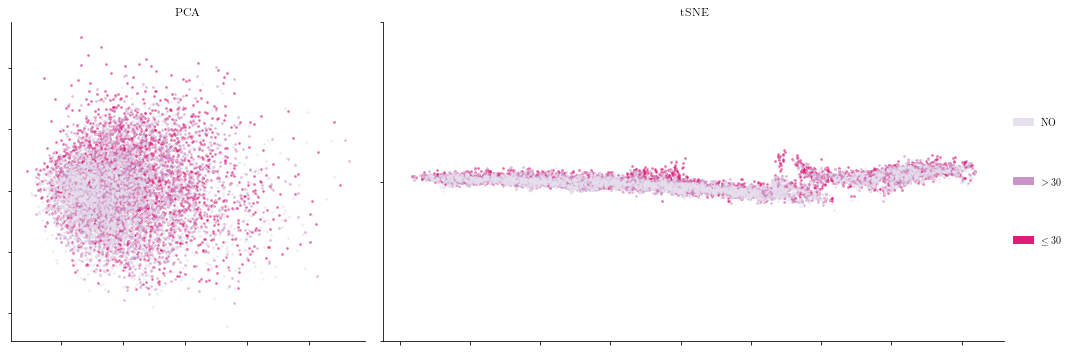

In [9]:
import matplotlib.patches as mpatches

from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

p1, p2 = pca_res[:, 0], pca_res[:, 1]
t1, t2 = tsne_res[:, 0], tsne_res[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.75]})
fig.tight_layout()
cats = ['NO', '>30', '<30'][::-1]
cols = ["#e7e1ef","#c994c7","#dd1c77"][::-1]
for cat,c in zip(cats, cols):
    inds = diab_labels == cat
    axes[0].scatter(p1[inds], p2[inds], s=3, c=c, alpha=0.5)
    axes[1].scatter(t1[inds], p2[inds], s=3, c=c, alpha=0.5)
cats = ['NO', r'$>30$', r'$\leq 30$'][::-1]
axes[1].set_yticks([-25, 0, 25])
axes[0].set_title("PCA")
axes[1].set_title("tSNE")
for ax in axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
patches = list(map(lambda p : mpatches.Patch(color=p[1], label=p[0]), zip(cats, cols)))
l = ax.legend(handles=list(map(lambda p : mpatches.Patch(color=p[0], label=p[1]), zip(cols, cats)))[::-1],
          bbox_to_anchor=(1, .5), loc='center left', labelspacing=5, frameon=False)
fig.tight_layout()
plt.savefig('dimred1.pdf', bbox_extra_artists=[l])

In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=28)
for train_inds, test_inds in splitter.split(data, data.readmitted):
    train_data, train_labels = data.iloc[train_inds], data['readmitted'].iloc[train_inds]
    test_data, test_labels = data.iloc[test_inds], data['readmitted'].iloc[test_inds]

train_labels_binary = train_labels != 'NO'
test_labels_binary = test_labels != 'NO'
    
train_data_prepared = full_pipeline.fit_transform(train_data)
test_data_prepared = full_pipeline.transform(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [20]:
from sklearn.base import ClassifierMixin
class StackingClassifier(ClassifierMixin):
    def __init__(self, base_classifiers, combiners, random_state=28, validation_split=0.3, include_data=True, soft_vote=True, **kwargs):
        self.base_cs = base_classifiers
        self.combiners = combiners
        self.seed = random_state
        self.split = validation_split
        self.data_forward = include_data
        self.soft_voting = soft_vote and all(map(lambda x: hasattr(x, 'predict_proba'), combiners))
        voting = 'soft' if self.soft_voting else 'hard'
        self.voter = VotingClassifier(estimators = list(map(lambda p: (str(p[0]), p[1]), enumerate(self.combiners))), voting=voting)
        self.classes_ = []
    def fit(self, X, y):
        samples, features = X.shape
        val = int(samples * self.split)
        X_val, X_train = X[:val, :], X[val:, :]
        y_val, y_train = y[:val], y[val:]
        for cl in self.base_cs:
            cl.fit(X_train, y_train)
        preds = [cl.predict_proba(X_val) for cl in self.base_cs]
        combiner_X = np.column_stack([np.column_stack(preds) ,X_val]) if self.data_forward else np.column_stack(preds)
        self.voter.fit(combiner_X, y_val)
        self.classes_ = self.voter.classes_
    def predict(self, X):
        preds = [cl.predict_proba(X) for cl in self.base_cs]
        combiner_X = np.column_stack([np.column_stack(preds) ,X]) if self.data_forward else np.column_stack(preds)
        return self.voter.predict(combiner_X)
    def decision_function(self, X):
        assert self.soft_voting
        preds = [cl.predict_proba(X) for cl in self.base_cs]
        combiner_X = np.column_stack([np.column_stack(preds) ,X]) if self.data_forward else np.column_stack(preds)
        return self.voter.predict_proba(combiner_X)
    def get_params(self, deep=True):
        kw = {'base_classifiers': self.base_cs,
         'combiners': self.combiners, 
         'random_state': self.seed,
         'validation_split': self.split,
         'include_data': self.data_forward,
         'soft_vote': self.soft_voting
        }
        return kw
    def set_params(self, **kw):
        return __init__(**kw)
    
from sklearn.svm.base import BaseSVC  

class MajorityClassifier(BaseSVC): # just something to make this thing work with cross_val_predict
    def __init__(self, C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated',
             coef0=0.0, shrinking=True, probability=False,
             tol=1e-3, cache_size=200, class_weight=None,
             verbose=False, max_iter=-1, decision_function_shape='ovr',
             random_state=None):
        self._impl = 'one_class'
        super().__init__(
            kernel=kernel, degree=degree, gamma=gamma,
            coef0=coef0, tol=tol, C=C, nu=0., shrinking=shrinking,
            probability=probability, cache_size=cache_size,
            class_weight=class_weight, verbose=verbose, max_iter=max_iter,
                decision_function_shape=decision_function_shape,
                random_state=random_state)

    def fit(self, X, y=None):
        vals, counts = np.unique(y, return_counts=True)
        self.majority = vals[counts.argmax()]
        self.dtype = y.dtype
    def predict(self, X):
        res = np.zeros((len(X), 1), dtype=self.dtype)
        res.fill(self.majority)
        return res

In [21]:
SEED = 28


gnb = GaussianNB()
mnb = MultinomialNB()
dte = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dtg = DecisionTreeClassifier(criterion='gini', random_state=SEED)
pct = SGDClassifier(loss='perceptron', random_state=SEED, max_iter=5, learning_rate='constant', 
                    tol=None, eta0=1, penalty=None)
sgd = SGDClassifier(random_state=SEED, n_jobs=-1)
svm = SVC(random_state=SEED, gamma='auto', probability=True)
log = LogisticRegression(random_state=SEED, solver='lbfgs', max_iter=200, n_jobs=-1)
knb = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)
maj = MajorityClassifier()

base_classifiers = [('Gaussian NB', gnb),
                    ('Multinomial NB', mnb),
                    ('Decision Tree (Entropy)', dte),
                    ('Decision Tree (Gini)', dtg),
                    ('Perceptron', pct),
                    ('Gradient Descent', sgd),
                    ('SVM', svm),
                    ('Logistic Regression', log),
                    ('K neighbours', knb),
                    ('Majority Classifier', maj)
                   ]

In [23]:
np.random.seed(SEED)

predictions = {}
for i, (name, cl) in enumerate(base_classifiers):
    print(name, i)
    if i != 1:
        yhat = cross_val_predict(cl, train_data_prepared, train_labels_binary, cv=10)
    else:
        yhat = cross_val_predict(cl, train_data_prepared-train_data_prepared.min(), train_labels_binary, cv=10)
    predictions[cl] = yhat
    print('','','','','', 'Recall:', recall_score(train_labels_binary, yhat))
    print('','','','','', 'Precision:', precision_score(train_labels_binary, yhat))
    print('','','','','', 'F1:', f1_score(train_labels_binary, yhat))
    print('','','','','', 'Accuracy:', accuracy_score(train_labels_binary, yhat))
    print(confusion_matrix(train_labels_binary, yhat))
    print()

Gaussian NB 0
     Recall: 0.36237397755373785
     Precision: 0.7878411910669976
     F1: 0.4964169381107492
     Accuracy: 0.5015475883415011
[[1984  513]
 [3352 1905]]

Multinomial NB 1
     Recall: 1.0
     Precision: 0.6779726592726335
     F1: 0.8080854661440321
     Accuracy: 0.6779726592726335
[[   0 2497]
 [   0 5257]]

Decision Tree (Entropy) 2
     Recall: 0.7220848392619365
     Precision: 0.7208507406000759
     F1: 0.721467262187589
     Accuracy: 0.6220015475883415
[[1027 1470]
 [1461 3796]]

Decision Tree (Gini) 3
     Recall: 0.7178999429332319
     Precision: 0.7253507591773977
     F1: 0.7216061185468451
     Accuracy: 0.6244518957957184
[[1068 1429]
 [1483 3774]]

Perceptron 4
     Recall: 0.7772493817766787
     Precision: 0.7179757511860833
     F1: 0.7464377055169893
     Accuracy: 0.6419912303327315
[[ 892 1605]
 [1171 4086]]

Gradient Descent 5
     Recall: 0.9191554118318432
     Precision: 0.711006474396704
     F1: 0.8017920849581017
     Accuracy: 0.6919009

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 7, 9, 10, 11, 13, 15, None], 
              'max_features': [10, 30, 40, 50, None],
              'criterion': ['entropy', 'gini'],
              'min_samples_split': [2,5,20,75,100,200, 300, 500],
             }
dt = DecisionTreeClassifier(random_state=SEED)

grid_search = GridSearchCV(dt, param_grid, cv=5,
                          scoring='balanced_accuracy', n_jobs=-1)

grid_search.fit(train_data_prepared, train_labels_binary)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=28,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 7, 9, 10, 11, 13, 15, None],
          

In [25]:
np.random.seed(SEED)
yhatdt = cross_val_predict(grid_search.best_estimator_, train_data_prepared, train_labels_binary, cv=10)
print('Recall:', recall_score(train_labels_binary, yhatdt))
print('Precision:', precision_score(train_labels_binary, yhatdt))
print('F1:', f1_score(train_labels_binary, yhatdt))
print('Accuracy:', accuracy_score(train_labels_binary, yhatdt))
print(grid_search.best_params_)
predictions[grid_search.best_estimator_] = yhatdt
confusion_matrix(train_labels_binary, yhatdt)


Recall: 0.8213810157884726
Precision: 0.7339792622811491
F1: 0.7752244165170556
Accuracy: 0.6770698994067578
{'criterion': 'entropy', 'max_depth': None, 'max_features': 50, 'min_samples_split': 100}


array([[ 932, 1565],
       [ 939, 4318]])

In [26]:
np.random.seed(SEED)
rf = RandomForestClassifier(random_state=SEED, criterion='entropy', max_features=50, min_samples_split=100, n_estimators=100)

predictions[rf] = cross_val_predict(rf, train_data_prepared, train_labels_binary, cv=10, n_jobs=-1)
print('Recall:', recall_score(train_labels_binary, predictions[rf]))
print('Precision:', precision_score(train_labels_binary, predictions[rf]))
print('F1:', f1_score(train_labels_binary, predictions[rf]))
print('Accuracy:', accuracy_score(train_labels_binary, predictions[rf]))
print(confusion_matrix(train_labels_binary, predictions[rf]))

Recall: 0.914780292942743
Precision: 0.7185118780815778
F1: 0.8048535564853555
Accuracy: 0.6992519989682744
[[ 613 1884]
 [ 448 4809]]


In [ ]:
vote = VotingClassifier([('dt', grid_search.best_estimator_), ('log', log), ('sgd', sgd), ('knb', knb)], voting='hard')
predictions[vote3] = cross_val_predict(vote3, train_data_prepared, train_labels_binary, cv=10, n_jobs=-1)
print('Recall:', recall_score(train_labels_binary, predictions[vote3]))
print('Precision:', precision_score(train_labels_binary, predictions[vote3]))
print('F1:', f1_score(train_labels_binary, predictions[vote3]))
print('Accuracy:', accuracy_score(train_labels_binary, predictions[vote3]))
print(confusion_matrix(train_labels_binary, predictions[vote3]))

In [ ]:
print('Recall:', recall_score(train_labels_binary, predictions[vote]))
print('Precision:', precision_score(train_labels_binary, predictions[vote]))
print('F1:', f1_score(train_labels_binary, predictions[vote]))
print('Accuracy:', accuracy_score(train_labels_binary, predictions[vote]))
print(confusion_matrix(train_labels_binary, predictions[vote]))

In [261]:
tmp = np.array(list(zip(predictions[grid_search.best_estimator_], 
                   predictions[log], 
                   predictions[sgd],
              )))

tmp2 = np.array(tmp.sum(axis=1) > 1, dtype=int)

tmp = list(zip(tmp[:,0], tmp[:,1], tmp[:,2], tmp2, train_labels_binary))

pd.Series(tmp).value_counts()

(1, 1, 1, 1, 1)    4027
(1, 1, 1, 1, 0)    1277
(0, 1, 1, 1, 1)     635
(0, 1, 1, 1, 0)     490
(0, 0, 0, 0, 0)     255
(0, 0, 0, 0, 1)     142
(1, 0, 0, 0, 0)     133
(0, 0, 1, 0, 0)     115
(1, 1, 0, 1, 1)     110
(1, 0, 0, 0, 1)      99
(0, 0, 1, 0, 1)      88
(1, 0, 1, 1, 1)      82
(1, 0, 1, 1, 0)      82
(0, 1, 0, 0, 1)      74
(1, 1, 0, 1, 0)      73
(0, 1, 0, 0, 0)      72
dtype: int64

In [36]:
np.random.seed(SEED)

ada = StackingClassifier(
            base_classifiers=[grid_search.best_estimator_, log, knb], 
            combiners=[LogisticRegression()], 
            random_state=SEED, include_data=False)

predictions[ada] = cross_val_predict(ada, train_data_prepared, train_labels_binary, cv=10)
print('Recall:', recall_score(train_labels_binary, predictions[ada]))
print('Precision:', precision_score(train_labels_binary, predictions[ada]))
print('F1:', f1_score(train_labels_binary, predictions[ada]))
print('Accuracy:', accuracy_score(train_labels_binary, predictions[ada]))
print(confusion_matrix(train_labels_binary, predictions[ada]))

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

Recall: 0.914209625261556
Precision: 0.7197843342818631
F1: 0.8054298642533936
Accuracy: 0.7005416559195254
[[ 626 1871]
 [ 451 4806]]


In [ ]:
cross_val_predict(ada, train_data_prepared, train_labels_binary, cv=10, method='decision_function')

In [225]:
vote

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features=50,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=100,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=28,
                                                     splitter='best')),
     

In [37]:
hardvote = VotingClassifier([('dt', grid_search.best_estimator_), ('log', log), ('sgd', sgd)], voting='hard')
softvote = VotingClassifier([('dt', grid_search.best_estimator_), ('log', log), ('knb', knb)], voting='soft')

In [38]:
predictions[softvote] = cross_val_predict(softvote, train_data_prepared, train_labels_binary, n_jobs=-1)
predictions[hardvote] = cross_val_predict(hardvote, train_data_prepared, train_labels_binary, n_jobs=-1)

/home/dks28/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [39]:
print('Recall:', recall_score(train_labels_binary, predictions[softvote]))
print('Precision:', precision_score(train_labels_binary, predictions[softvote]))
print('F1:', f1_score(train_labels_binary, predictions[softvote]))
print('Accuracy:', accuracy_score(train_labels_binary, predictions[softvote]))
print(confusion_matrix(train_labels_binary, predictions[softvote]))

Recall: 0.9229598630397565
Precision: 0.7099795141937372
F1: 0.8025804317260772
Accuracy: 0.6921588857363942
[[ 515 1982]
 [ 405 4852]]


In [40]:
predictions[hardvote] = tmp2
print('Recall:', recall_score(train_labels_binary, predictions[hardvote]))
print('Precision:', precision_score(train_labels_binary, predictions[hardvote]))
print('F1:', f1_score(train_labels_binary, predictions[hardvote]))
print('Accuracy:', accuracy_score(train_labels_binary, predictions[hardvote]))
print(confusion_matrix(train_labels_binary, predictions[hardvote]))

NameError: name 'tmp2' is not defined

In [237]:
predictions

{GaussianNB(priors=None, var_smoothing=1e-09): array([0, 1, 0, ..., 0, 0, 0]),
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True): array([1, 1, 1, ..., 1, 1, 1]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=28, splitter='best'): array([0, 1, 0, ..., 1, 0, 1]),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_s

In [41]:
accs = {}
maxk = None
maxacc = -np.inf
for k, v in predictions.items():
    accs[k] = accuracy_score(train_labels_binary, v)
    if accs[k] > maxacc:
        maxk = k
        maxacc = accs[k]

maxacc

0.7005416559195254

In [42]:
maxk

In [43]:
predictions['adaboost'] = cross_val_predict(AdaBoostClassifier(log,algorithm="SAMME.R", random_state=SEED, n_estimators=100),train_data_prepared,train_labels_binary, cv=10, n_jobs=-1)

KeyboardInterrupt: 

In [ ]:
print('Recall:', recall_score(train_labels_binary, predictions['adaboost']))
print('Precision:', precision_score(train_labels_binary, predictions['adaboost']))
print('F1:', f1_score(train_labels_binary, predictions['adaboost']))
print('Accuracy:', accuracy_score(train_labels_binary, predictions['adaboost']))
print(confusion_matrix(train_labels_binary, predictions['adaboost']))

In [44]:
confslog = cross_val_predict(log, train_data_prepared, train_labels_binary, cv=10, method='predict_proba')[:,1]
confsrf  = cross_val_predict(rf,  train_data_prepared, train_labels_binary, cv=10, method='predict_proba')[:,1]
confsstc = cross_val_predict(ada, train_data_prepared, train_labels_binary, cv=10, method='decision_function')[:,1]

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

In [45]:
preclog, reclog, thlog = precision_recall_curve(train_labels_binary, confslog)
precrf , recrf , thrf  = precision_recall_curve(train_labels_binary, confsrf)
precstc, recstc, thstc = precision_recall_curve(train_labels_binary, confsstc)


In [62]:
def plot_pr_vs_threshold(precisions, recalls, thresholds, name='Classifier'):
    phi = (np.sqrt(5) + 1) / 2 
    fig, axes = plt.subplots(1,2,figsize=(phi*6+7, 6), gridspec_kw={'width_ratios': [phi, 1]})
    ax = axes[0]
    ax.plot([0] + list(thresholds)+[1], [np.min(precisions)] + list(precisions), "#518FA9", label="Precision", linewidth=2)
    ax.plot([0] + list(thresholds)+[1], [np.max(recalls)] + list(recalls), "#E8B1EC", label="Recall", linewidth=2)
    ax.set_xlabel(f"{name} Conservativeness", horizontalalignment='center')
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([-0.025, 1.025])
    ax.locator_params(axis='x', nbins=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color("white")
    ax.spines['bottom'].set_color("white")
    ax.grid(color='#DDDDDD')
    list(map(lambda ts: ts.set_color('white'),ax.xaxis.get_majorticklines()))
    list(map(lambda ts: ts.set_color('white'),ax.yaxis.get_majorticklines()))
    ax.text(x=.82, y=.2, verticalalignment='bottom', horizontalalignment='right', s='Recall', fontsize=15)
    ax.text(x=.17, y=.6, verticalalignment='bottom', horizontalalignment='left', s='Precision', fontsize=15)

    ax = axes[1]
    ax.plot(recalls, precisions, color='#518FA9')
    ax.set_xlim([-0.025, 1.025])
    ax.set_ylim([0.4875, 1.0125])
    ax.set_yticks([0.6,0.8,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color("white")
    ax.spines['bottom'].set_color("white")
    list(map(lambda ts: ts.set_color('white'),ax.xaxis.get_majorticklines()))
    list(map(lambda ts: ts.set_color('white'),ax.yaxis.get_majorticklines()))
    ax.grid(color='#DDDDDD')
    ax.set_ylabel('Precision', rotation=0, horizontalalignment='right')
    ax.set_xlabel('Recall', rotation=0, horizontalalignment='center')

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)


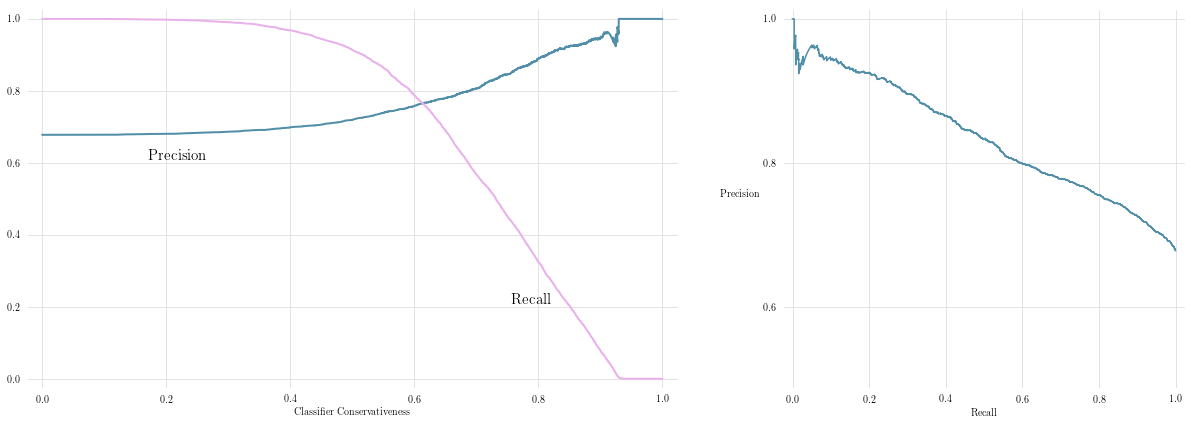

In [63]:
plot_pr_vs_threshold(precstc, recstc, thstc)
plt.savefig('precrecstack.pdf')

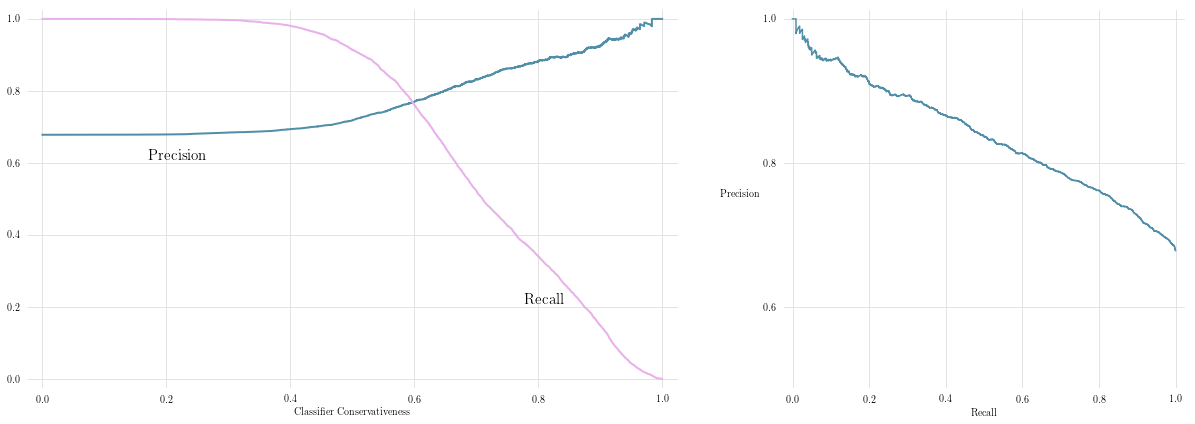

In [48]:
plot_pr_vs_threshold(precrf, recrf, thrf)
plt.savefig('precrecrf.pdf')

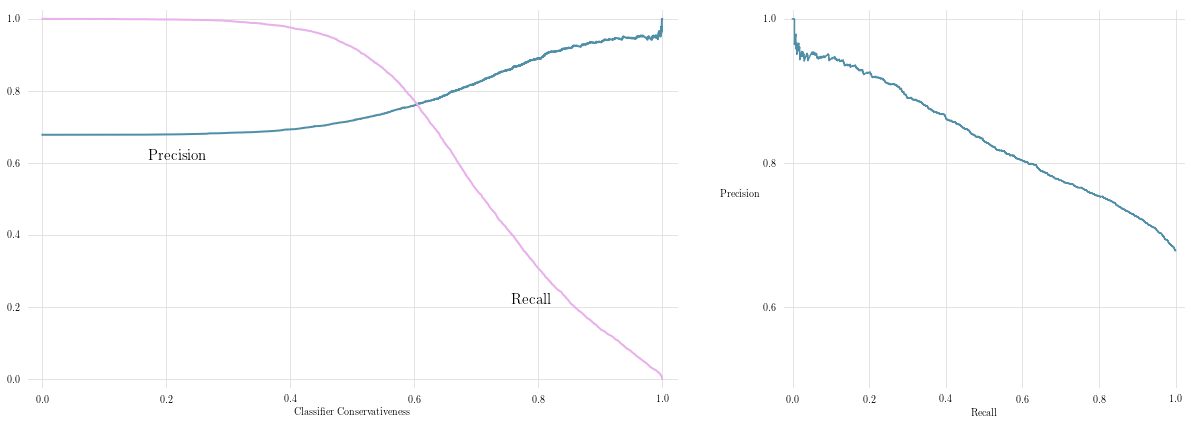

In [64]:
plot_pr_vs_threshold(preclog, reclog, thlog)
plt.savefig('precreclog.pdf')

In [82]:
def plot_roc_curve(fpr, tpr, fig, ax, auc, label=None):
    ax.plot([0,0,1], [0,1,1], color='#AAAAAA', linewidth=0.35)
    ax.plot(fpr, tpr, label=label, linewidth=2.5, color='#518FA9')
    ax.axis([-0.025, 1, 0, 1.01])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive \nRate (TPR)", rotation=0, horizontalalignment='left', labelpad=30, )
    ax.fill(list(fpr)+[1], list(tpr)+[0], color='#518FA9', alpha=0.4)
    ax.grid(color='white', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    list(map(lambda ts: ts.set_color('white'),ax.xaxis.get_majorticklines()))
    list(map(lambda ts: ts.set_color('white'),ax.yaxis.get_majorticklines()))
    ax.text(x=0.96, y=0.14, s="Area under curve: " + str(np.round(100*auc, decimals=2)) + "\%", fontsize=15, horizontalalignment='right', verticalalignment='top')
    ax.set_aspect('equal')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

In [51]:
(fpr_log, tpr_log, th_log), auc_log  = roc_curve(train_labels_binary, confslog), roc_auc_score(train_labels_binary, confslog)
(fpr_rf, tpr_rf, th_rf), auc_rf  = roc_curve(train_labels_binary, confsrf), roc_auc_score(train_labels_binary, confsrf)
(fpr_stc, tpr_stc, th_stc), auc_stc  = roc_curve(train_labels_binary, confsstc), roc_auc_score(train_labels_binary, confsstc)


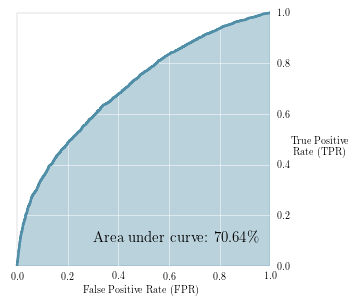

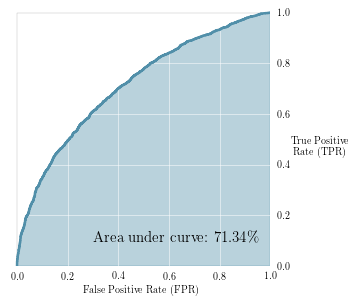

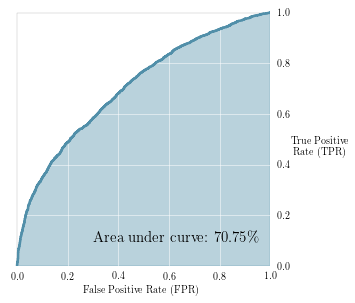

In [83]:
fig, axes = plt.subplots(figsize=(5,5))
plot_roc_curve(fpr_log, tpr_log, fig, axes, auc_log)
#plot_roc_curve(fpr_rf, tpr_rf, fig,axes[1], auc_rf)
#plot_roc_curve(fpr_stc, tpr_stc, fig,axes[2], auc_stc)
fig.tight_layout()
plt.savefig('roclog.pdf')
plt.show()
fig, axes = plt.subplots(figsize=(5,5))
plot_roc_curve(fpr_rf, tpr_rf, fig,axes, auc_rf)
fig.tight_layout()
plt.savefig('rocrf.pdf')
plt.show()
fig, axes = plt.subplots(figsize=(5,5))
plot_roc_curve(fpr_stc, tpr_stc, fig,axes, auc_stc)
fig.tight_layout()
plt.savefig('rocstc.pdf')
plt.show()

Accuracy: 0.5029662109878772
[[1504  582  539]
 [ 728 1027  877]
 [ 426  702 1369]]


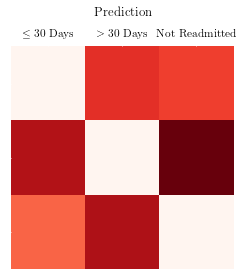

In [53]:
np.random.seed(SEED)

grid_search.best_estimator_.set_params(**{'max_features':20})

adam = StackingClassifier(
            base_classifiers=[grid_search.best_estimator_, log, knb], 
            combiners=[LogisticRegression()], 
            random_state=SEED, include_data=False)

predictions[adam] = cross_val_predict(adam, train_data_prepared, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[adam]))
print(confusion_matrix(train_labels, predictions[adam]))

missclshtmp(predictions[adam])
plt.savefig('stchtmp.pdf')

(7754, 20)
Accuracy: 0.5095434614392571
[[1565  576  484]
 [ 830 1003  799]
 [ 466  648 1383]]


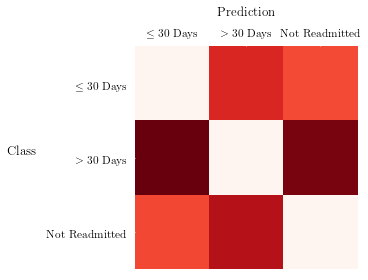

In [54]:
print(reduced_train.shape)
np.random.seed(SEED)
rfm = RandomForestClassifier(random_state=SEED, criterion='entropy', max_features=15, min_samples_split=100, n_estimators=100)
predictions[rfm] = cross_val_predict(rfm, train_data_prepared, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[rfm]))
print(confusion_matrix(train_labels, predictions[rfm]))

missclshtmp(predictions[rfm], y=True)
plt.savefig('rfhtmp.pdf')

Accuracy: 0.4958730977559969
[[1449  663  513]
 [ 714 1111  807]
 [ 434  778 1285]]


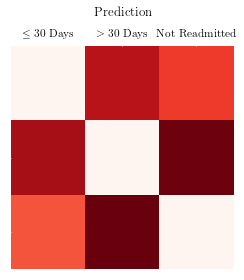

In [55]:
np.random.seed(SEED)

logm = LogisticRegression(random_state=SEED, solver='lbfgs', max_iter=200, n_jobs=-1)
predictions[logm] = cross_val_predict(logm, train_data_prepared, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[logm]))
print(confusion_matrix(train_labels, predictions[logm]))

missclshtmp(predictions[logm])
plt.savefig('loghtmp.pdf')

Accuracy: 0.4899406757802425
[[1603  536  486]
 [ 900  946  786]
 [ 582  665 1250]]


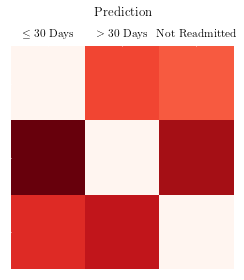

In [56]:
np.random.seed(SEED)

hardm = VotingClassifier([('dt', grid_search.best_estimator_), ('log', log), ('sgd', sgd)], voting='hard')
predictions[hardm] = cross_val_predict(hardm, train_data_prepared, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[hardm]))
print(confusion_matrix(train_labels, predictions[hardm]))

missclshtmp(predictions[hardm])
plt.savefig('hvthtmp.pdf')

In [747]:
logm.fit(train_data_prepared, train_labels)
logm.coef_

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([[ 6.06313874e-01,  1.55953223e-02, -2.62461875e-02,
        -1.17879166e-01,  2.33994362e-01,  6.73166230e-01,
         6.49051511e-02,  8.63024959e-02,  4.79037559e-02,
        -6.83054957e-01, -2.74064980e-01, -8.00206695e-02,
        -1.50553329e-01, -9.42031091e-01,  4.88612691e-02,
        -1.17635441e+00, -6.54628077e-02, -5.07550897e-01,
        -5.38542332e-01, -2.12857678e-01, -1.85180230e-01,
         4.47543313e-01,  3.91387426e-01, -1.90679154e-01,
         4.25824268e-01,  3.68938243e-01,  3.13422372e-01,
         4.19812910e-01,  6.38228156e-01,  1.84477419e-01,
         4.51024887e-01,  4.47108553e-01,  4.85140320e-01,
         4.05439666e-01,  4.82601303e-01,  4.42734520e-02,
         2.81705377e-01,  6.11792958e-01,  8.17661914e-01,
         2.72594380e-01, -2.44796531e-01,  5.14349631e-01,
        -1.30396995e-01,  1.86533141e-01, -3.45261257e-01,
         2.31216789e-02,  3.61132142e-02, -1.06586695e-01,
         1.60173024e-02,  3.48841676e-02,  1.15675558e-0

In [755]:
rf.fit(train_data_prepared, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [31]:
from sklearn.kernel_approximation import RBFSampler

rf.fit(train_data_prepared, train_labels)
impf = rf.feature_importances_.argsort()[::-1][:20]
reduced_train = train_data_prepared[:, impf]
#rbf_features = RBFSampler(gamma=1, random_state=28)
#reduced_train = rbf_features.fit_transform(reduced_train)

pca2 = PCA()
tsne2 = TSNE(n_components=2, verbose=1)

reduced_data = prepared_data[:, impf]

pca_res = pca2.fit_transform(reduced_data)
tsne_res = tsne2.fit_transform(reduced_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9693 samples in 0.097s...
[t-SNE] Computed neighbors for 9693 samples in 2.897s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9693
[t-SNE] Computed conditional probabilities for sample 2000 / 9693
[t-SNE] Computed conditional probabilities for sample 3000 / 9693
[t-SNE] Computed conditional probabilities for sample 4000 / 9693
[t-SNE] Computed conditional probabilities for sample 5000 / 9693
[t-SNE] Computed conditional probabilities for sample 6000 / 9693
[t-SNE] Computed conditional probabilities for sample 7000 / 9693
[t-SNE] Computed conditional probabilities for sample 8000 / 9693
[t-SNE] Computed conditional probabilities for sample 9000 / 9693
[t-SNE] Computed conditional probabilities for sample 9693 / 9693
[t-SNE] Mean sigma: 0.744827
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.538864
[t-SNE] KL divergence after 1000 iterations: 2.191725


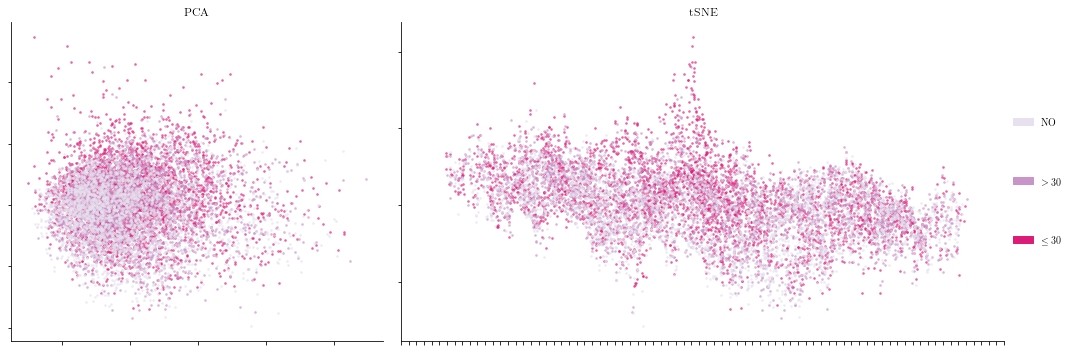

In [35]:
p1, p2 = pca_res[:, 0], pca_res[:, 1]
t1, t2 = tsne_res[:, 0], tsne_res[:, 1]

phi = (np.sqrt(5) + 1) / 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, phi]})
fig.tight_layout()
cats = ['NO', '>30', '<30'][::-1]
cols = ["#e7e1ef","#c994c7","#dd1c77"][::-1]
for cat,c in zip(cats, cols):
    inds = diab_labels == cat
    axes[0].scatter(p1[inds], p2[inds], s=3, c=c, alpha=0.5)
    axes[1].scatter(t1[inds], p2[inds], s=3, c=c, alpha=0.5)
cats = ['NO', r'$>30$', r'$\leq 30$'][::-1]
axes[1].set_yticks([-2.5, 0, 2.5, 5])
axes[1].set_xticks(np.arange(-100, 100, 2.5))
axes[0].set_title("PCA")
axes[1].set_title("tSNE")
for ax in axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
patches = list(map(lambda p : mpatches.Patch(color=p[1], label=p[0]), zip(cats, cols)))
l = ax.legend(handles=list(map(lambda p : mpatches.Patch(color=p[0], label=p[1]), zip(cols, cats)))[::-1],
          bbox_to_anchor=(1, .5), loc='center left', labelspacing=5, frameon=False)
fig.tight_layout()
plt.savefig('dimred2.pdf', bbox_extra_artists=[l])


In [766]:
reduced_data.shape

(7754, 20)

In [778]:
diab_features

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,booleanGlucose,discharge_disposition_cat,admission_source_cat,admission_type_cat,UP,STEADY,DOWN,total_visits,diagnoses,diagnoses_nocat
0,Caucasian,Female,0,6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,NULL,REFERRAL,NULL,0,0,0,0,[DIABETES],[250.83]
1,Caucasian,Female,1,1,1,7,3,NaN,59,0,...,0,CARE_CONTINUES_ELSEWHERE,E.R.,Emergency,1,0,0,0,"[ENDOCRINE_METABOLIC, DIABETES, ENDOCRINE_META...","[276, 250.01, 255]"
2,AfricanAmerican,Female,2,1,1,7,2,NaN,11,5,...,0,CARE_CONTINUES_ELSEWHERE,E.R.,Emergency,0,1,0,3,"[PREGNANCY_COMPLICATIONS, ENDOCRINE_METABOLIC,...","[648, 250, V27]"
3,Caucasian,Male,3,1,1,7,2,NaN,44,1,...,0,CARE_CONTINUES_ELSEWHERE,E.R.,Emergency,1,0,0,0,"[INFECTIOUS_PARASITIC, DIABETES, CIRCULATORY]","[8, 250.43, 403]"
4,Caucasian,Male,4,1,1,7,1,NaN,51,0,...,0,CARE_CONTINUES_ELSEWHERE,E.R.,Emergency,0,2,0,0,"[NEOPLASMS, NEOPLASMS, ENDOCRINE_METABOLIC]","[197, 157, 250]"
5,Caucasian,Male,5,2,1,2,3,NaN,31,6,...,0,CARE_CONTINUES_ELSEWHERE,REFERRAL,Urgent,0,1,0,0,"[CIRCULATORY, CIRCULATORY, ENDOCRINE_METABOLIC]","[414, 411, 250]"
6,Caucasian,Male,6,3,1,2,4,NaN,70,1,...,0,CARE_CONTINUES_ELSEWHERE,REFERRAL,Elective,0,3,0,0,"[CIRCULATORY, CIRCULATORY, SUPP_CLASS_HEALTH_F...","[414, 411, V45]"
7,Caucasian,Male,7,1,1,7,5,NaN,73,0,...,0,CARE_CONTINUES_ELSEWHERE,E.R.,Emergency,0,1,0,0,"[CIRCULATORY, RESPIRATORY, ENDOCRINE_METABOLIC]","[428, 492, 250]"
8,Caucasian,Female,8,2,1,4,13,NaN,68,2,...,0,CARE_CONTINUES_ELSEWHERE,TRANSFER,Urgent,0,2,0,0,"[CIRCULATORY, CIRCULATORY, INFECTIOUS_PARASITIC]","[398, 427, 38]"
9,Caucasian,Female,9,3,3,4,12,InternalMedicine,33,3,...,0,ICF/SNF,TRANSFER,Elective,0,2,0,0,"[CIRCULATORY, NEOPLASMS, RESPIRATORY]","[434, 198, 486]"


In [57]:
ada.fit(train_data_prepared, train_labels_binary)
testpredada = ada.predict(test_data_prepared)

print('Recall:', recall_score(test_labels_binary, testpredada))
print('Precision:', precision_score(test_labels_binary, testpredada))
print('F1:', f1_score(test_labels_binary, testpredada))
print('Accuracy:', accuracy_score(test_labels_binary, testpredada))
print(confusion_matrix(test_labels_binary, testpredada))

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall: 0.9346007604562737
Precision: 0.7220916568742656
F1: 0.8147166058999005
Accuracy: 0.7117070654976793
[[ 151  473]
 [  86 1229]]


In [58]:
rf.fit(train_data_prepared, train_labels_binary)
testpredrf = rf.predict(test_data_prepared)

print('Recall:', recall_score(test_labels_binary, testpredrf))
print('Precision:', precision_score(test_labels_binary, testpredrf))
print('F1:', f1_score(test_labels_binary, testpredrf))
print('Accuracy:', accuracy_score(test_labels_binary, testpredrf))
print(confusion_matrix(test_labels_binary, testpredrf))

Recall: 0.9285171102661597
Precision: 0.7246290801186943
F1: 0.814
Accuracy: 0.7122227952552862
[[ 160  464]
 [  94 1221]]


In [59]:
log.fit(train_data_prepared, train_labels_binary)
testpredlog = log.predict(test_data_prepared)

print('Recall:', recall_score(test_labels_binary, testpredlog))
print('Precision:', precision_score(test_labels_binary, testpredlog))
print('F1:', f1_score(test_labels_binary, testpredlog))
print('Accuracy:', accuracy_score(test_labels_binary, testpredlog))
print(confusion_matrix(test_labels_binary, testpredlog))

Recall: 0.9307984790874525
Precision: 0.7162083089526039
F1: 0.8095238095238095
Accuracy: 0.70293965961836
[[ 139  485]
 [  91 1224]]


In [60]:
hardvote.fit(train_data_prepared, train_labels_binary)
testpredhavo = hardvote.predict(test_data_prepared)

print('Recall:', recall_score(test_labels_binary, testpredhavo))
print('Precision:', precision_score(test_labels_binary, testpredhavo))
print('F1:', f1_score(test_labels_binary, testpredhavo))
print('Accuracy:', accuracy_score(test_labels_binary, testpredhavo))
print(confusion_matrix(test_labels_binary, testpredhavo))

Recall: 0.9315589353612167
Precision: 0.7151196730881495
F1: 0.8091149273447821
Accuracy: 0.7019082001031459
[[ 136  488]
 [  90 1225]]


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.5048994326972667
[[372 157 128]
 [202 259 197]
 [101 175 348]]


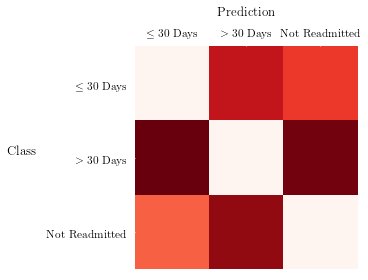

In [81]:
np.random.seed(SEED)

adam.fit(train_data_prepared, train_labels)
testpredadam = adam.predict(test_data_prepared)

print('Accuracy:', accuracy_score(test_labels, testpredadam))
print(confusion_matrix(test_labels, testpredadam))

missclshtmp(testpredadam, test=True, y=True)
plt.savefig('stchtmptest.pdf')

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.4961320268179474
[[356 184 117]
 [194 286 178]
 [102 202 320]]


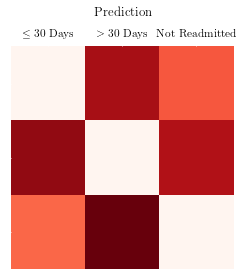

In [75]:
np.random.seed(SEED)

logm.fit(train_data_prepared, train_labels)
testpredlogm = logm.predict(test_data_prepared)

print('Accuracy:', accuracy_score(test_labels, testpredlogm))
print(confusion_matrix(test_labels, testpredlogm))

missclshtmp(testpredlogm, test=True)
plt.savefig('loghtmptest.pdf')

Accuracy: 0.5018050541516246
[[397 143 117]
 [217 250 191]
 [122 176 326]]


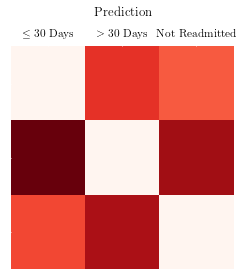

In [77]:
np.random.seed(SEED)

rfm.fit(train_data_prepared, train_labels)
testpredrfm = rfm.predict(test_data_prepared)

print('Accuracy:', accuracy_score(test_labels, testpredrfm))
print(confusion_matrix(test_labels, testpredrfm))

missclshtmp(testpredrfm, test=True)
plt.savefig('rfhtmptest.pdf')

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.5028365136668386
[[397 143 117]
 [217 250 191]
 [122 176 326]]


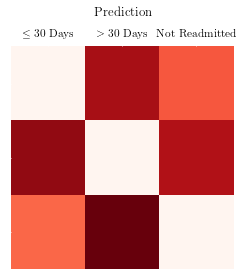

In [78]:
np.random.seed(SEED)

hardvote.fit(train_data_prepared, train_labels)
testpredhvt = hardvote.predict(test_data_prepared)

print('Accuracy:', accuracy_score(test_labels, testpredhvt))
print(confusion_matrix(test_labels, testpredrfm))

missclshtmp(testpredlogm, test=True)
plt.savefig('hvthtmptest.pdf')

Accuracy: 0.501418622646376
[[1456  637  532]
 [ 716 1029  887]
 [ 427  667 1403]]


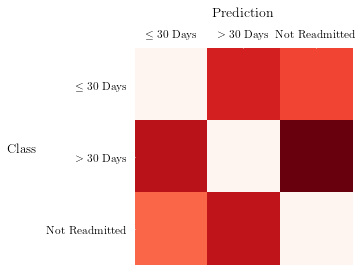

In [925]:
np.random.seed(SEED)

grid_search.best_estimator_.set_params(**{'max_features':20})

adamr = StackingClassifier(
            base_classifiers=[grid_search.best_estimator_, log, knb], 
            combiners=[LogisticRegression()], 
            random_state=SEED, include_data=False)

predictions[adamr] = cross_val_predict(adam, reduced_train, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[adamr]))
print(confusion_matrix(train_labels, predictions[adamr]))

missclshtmp(predictions[adamr])
plt.savefig('stchtmp.pdf')

(7754, 20)
Accuracy: 0.4966468919267475
[[1520  604  501]
 [ 778  997  857]
 [ 453  710 1334]]


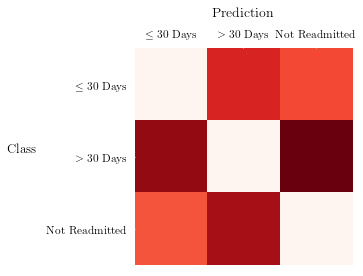

In [926]:
print(reduced_train.shape)
np.random.seed(SEED)
rfmr = RandomForestClassifier(random_state=SEED, criterion='entropy', max_features=15, min_samples_split=100, n_estimators=100)
predictions[rfmr] = cross_val_predict(rfmr, reduced_train, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[rfmr]))
print(confusion_matrix(train_labels, predictions[rfmr]))

missclshtmp(predictions[rfmr])
plt.savefig('rfmhtmp.pdf')

In [840]:
np.random.seed(SEED)

logm = LogisticRegression(random_state=SEED, solver='lbfgs', max_iter=200, n_jobs=-1)
predictions[logm] = cross_val_predict(logm, train_data_prepared, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[logm]))
print(confusion_matrix(train_labels, predictions[logm]))

Accuracy: 0.4958730977559969
[[1449  663  513]
 [ 714 1111  807]
 [ 434  778 1285]]


Accuracy: 0.4868454990972401
[[1567  537  521]
 [ 910  900  822]
 [ 606  583 1308]]


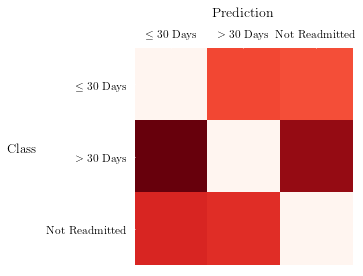

In [922]:
np.random.seed(SEED)

hardmr = VotingClassifier([('dt', grid_search.best_estimator_), ('log', log), ('sgd', sgd)], voting='hard')
predictions[hardmr] = cross_val_predict(hardmr, reduced_train, train_labels, cv=10, n_jobs=-1)

print('Accuracy:', accuracy_score(train_labels, predictions[hardmr]))
print(confusion_matrix(train_labels, predictions[hardmr]))



In [70]:
def missclshtmp(preds, y=False, test=False):
    conf_mx = confusion_matrix(train_labels if not test else test_labels, preds)
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    fig, ax = plt.subplots(figsize=(4,4)) if not y else plt.subplots(figsize=(6,4))
    ax.imshow(norm_conf_mx, cmap = "Reds")
    ax.set_xticks([0,1,2])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_yticks([0,1,2])
    list(map(lambda ts: ts.set_color('white'),ax.xaxis.get_majorticklines()))
    list(map(lambda ts: ts.set_color('white'),ax.yaxis.get_majorticklines()))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([r"$\leq 30$ Days", r"$>30$ Days", "Not Readmitted" ], fontsize=11.5)
    ax.set_xlabel('Prediction',  horizontalalignment='center', labelpad=10, fontsize=13)#
    if y:
        ax.set_yticklabels([r"$\leq 30$ Days", r"$>30$ Days", "Not Readmitted" ], fontsize=11.5)
        ax.set_ylabel('Class', rotation=0, horizontalalignment='right', labelpad=10, fontsize=13)
    else:
        ax.set_yticklabels([])
    fig.tight_layout()